In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import stft
from numpy.fft import fft, fftfreq, fftshift
from cfo_estimation.blue import cfo_est_blue as estimator

In [2]:
frequency_offset_test_cases = np.arange(-200000, 200000, 1000)  # Cycles per second
sampling_frequency = 1500000    # Samples per second
acceptable_error = 100  # Cycles per second offset

In [3]:
# Test Signal Parameters
signal_length_s = 4 # s
sampling_freq_hz = 1000000 # Hz
center_freq_hz = 172000000 # Hz
offset_freq_hz = 5000 # Hz offset from center
ping_duration_s = 0.05 # s
ping_period_s = 1 # s
ping_power_db = -30 # dB
noise_power_db = -60 # dB

In [4]:
def generate_test_signal(
        signal_length_s: float = 4.0,
        sampling_freq_hz: float = 1e6,
        offset_freq_hz: float = 5e3,
        ping_duration_s: float = 50e-3,
        ping_period_s: float = 1.0,
        ping_power_db: float = -30.0,
        noise_power_db: float = -60.0) -> np.ndarray:
    # Computed signal parameters
    ping_amplitude = 10 ** (ping_power_db / 20) # FS
    ping_time_index = np.arange(0, ping_duration_s, 1/sampling_freq_hz)
    offset_freq_rad_p_sample = offset_freq_hz * 2 * np.pi
    ping_phase_seq_rad = offset_freq_rad_p_sample * ping_time_index
    ping_signal = np.cos(ping_phase_seq_rad) + 1j * np.sin(ping_phase_seq_rad)

    noise_snr = 10.0 ** (noise_power_db / 10.0)
    noise_length_s = ping_period_s - ping_duration_s
    noise_length_samples = int(noise_length_s * sampling_freq_hz)
    noise_stddev_amplitude = np.sqrt(noise_snr*2.0)/2.0
    ping_wait_signal = np.random.normal(loc=0,
                                        scale=noise_stddev_amplitude,
                                        size=(noise_length_samples, 2)).view(np.complex128) # Generate noise with calculated power
    ping_wait_signal = np.squeeze(ping_wait_signal)
    noise_component = np.random.normal(loc=0,
                                    scale=noise_stddev_amplitude,
                                    size=(len(ping_signal), 2)).view(np.complex128)
    noise_component = np.squeeze(noise_component)
    ping_signal_noise = ping_amplitude * ping_signal + noise_component # Generate noise with calculated power

    signal = np.array([0.00001])
    golden_ping_idx = []
    for _ in range(int(signal_length_s / ping_period_s)):
        signal = np.append(signal, ping_signal_noise)
        golden_ping_idx.append(len(signal))
        signal = np.append(signal, ping_wait_signal)
    signal = np.append(signal, ping_signal_noise)
    return signal

In [5]:
# signal = generate_test_signal(signal_length_s=signal_length_s,
#                               sampling_freq_hz=sampling_freq_hz,
#                               offset_freq_hz=offset_freq_hz,
#                               ping_duration_s=ping_duration_s,
#                               ping_period_s=ping_period_s,
#                               ping_power_db=ping_power_db,
#                               noise_power_db=noise_power_db)
# plt.specgram(signal,
#              NFFT=1024,
#              Fs=sampling_freq_hz)
# plt.grid()
# plt.xlabel('Time (s)')
# plt.ylabel('Offset (Hz)')

In [6]:
errors = []
for test_freq in frequency_offset_test_cases:
    test_signal = generate_test_signal(signal_length_s=signal_length_s,
                              sampling_freq_hz=sampling_freq_hz,
                              offset_freq_hz=test_freq,
                              ping_duration_s=ping_duration_s,
                              ping_period_s=ping_period_s,
                              ping_power_db=ping_power_db,
                              noise_power_db=noise_power_db)
    cfo_est = estimator(test_signal, f_s=sampling_freq_hz)
    error = abs(cfo_est - test_freq)
    errors.append(error)

Text(0.5, 1.0, 'Estimator performance')

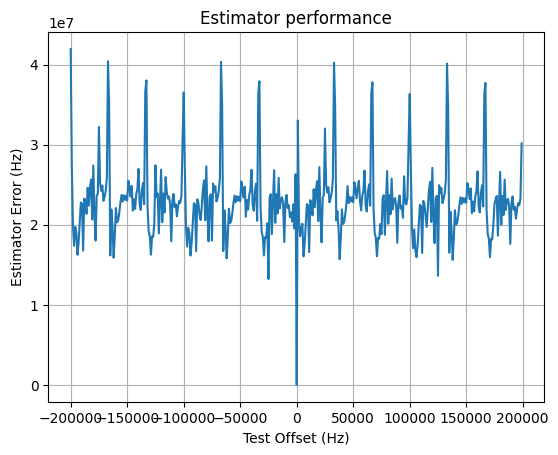

In [7]:
plt.plot(frequency_offset_test_cases, errors)
plt.xlabel('Test Offset (Hz)')
plt.ylabel('Estimator Error (Hz)')
plt.grid()
plt.title('Estimator performance')